## 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split

import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image

import matplotlib.pyplot as plt
import numpy as np

from data import split_dataset, transform_to_tensor, transform_normalize, transform_to_image
from model import PneumoniaDetectionResNetModel
from trainer import Trainer

## 2. Dataset

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

In [2]:
raw_train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transform_to_tensor)

original_train_set = torchvision.datasets.ImageFolder(root="data/train", transform=transforms.Compose([transform_to_tensor, transform_normalize]))
original_validation_set = torchvision.datasets.ImageFolder(root="data/val", transform=transforms.Compose([transform_to_tensor, transform_normalize]))
merged_dataset = ConcatDataset([original_train_set, original_validation_set])
train_set, validation_set = split_dataset(merged_dataset, 0.7)

test_set = torchvision.datasets.ImageFolder(root="data/test", transform=transforms.Compose([transform_to_tensor, transform_normalize]))

classes = test_set.classes
print(f"Classes: {test_set.class_to_idx}")

Classes: {'NORMAL': 0, 'PNEUMONIA': 1}


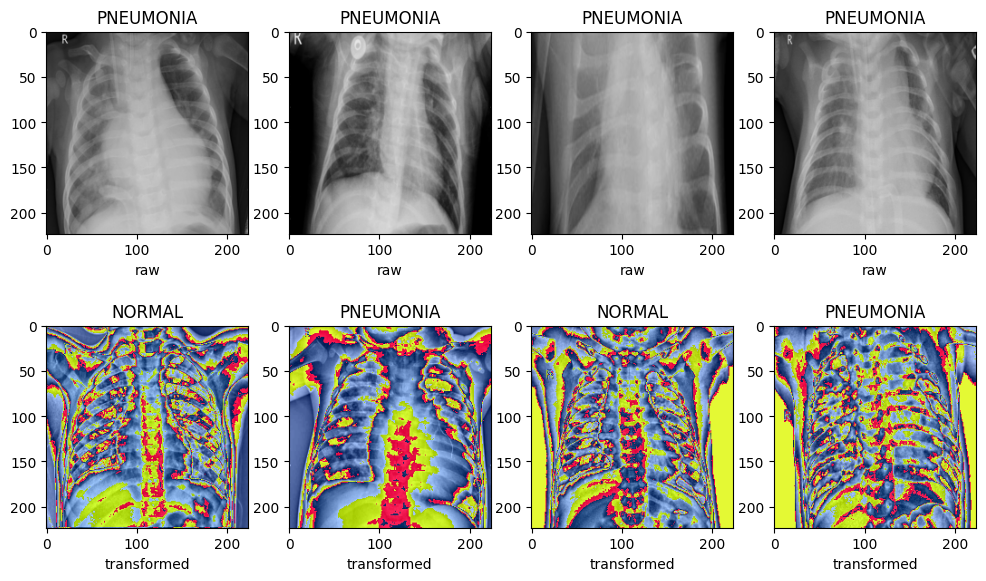

In [3]:
batch_size = 64
raw_train_loader = DataLoader(raw_train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(333))
validation_loader = DataLoader(validation_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

dataiter = iter(train_loader)
train_images, train_labels = next(dataiter)

dataiter = iter(raw_train_loader)
raw_images, raw_labels = next(dataiter)

figure = plt.figure(figsize=(12, 7))
cols, rows = 4,2
for i in range(1, cols * rows + 1):
    if i <= 4:
        figure.add_subplot(rows, cols, i)
        plt.title(classes[raw_labels[i]])
        plt.xlabel("raw")
        plt.imshow(transform_to_image(raw_images[i]))
    else:
        figure.add_subplot(rows, cols, i)
        plt.title(classes[train_labels[i]])
        plt.xlabel("transformed")
        plt.imshow(transform_to_image(train_images[i]))
plt.show()

## 3. Model

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = PneumoniaDetectionResNetModel()
print(model)


PneumoniaDetectionResNetModel(
  (transforms): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## 4. Train

In [5]:
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, train_loader, validation_loader, adam_optimizer, loss_fn=loss_fn, device=device, epochs=5)

In [6]:
trainer.fit()

Epoch [1/5], Step [0/58], Loss: 0.5565
Epoch [1/5], Step [10/58], Loss: 0.0443
Epoch [1/5], Step [20/58], Loss: 0.1145
Epoch [1/5], Step [30/58], Loss: 0.0358
Epoch [1/5], Step [40/58], Loss: 0.0372
Epoch [1/5], Step [50/58], Loss: 0.0089
Validation loss: 0.36245016813278197
Epoch [2/5], Step [0/58], Loss: 0.0219
Epoch [2/5], Step [10/58], Loss: 0.1473
Epoch [2/5], Step [20/58], Loss: 0.0298
Epoch [2/5], Step [30/58], Loss: 0.0762
Epoch [2/5], Step [40/58], Loss: 0.0130
Epoch [2/5], Step [50/58], Loss: 0.0407
Validation loss: 0.13603834941983223
Epoch [3/5], Step [0/58], Loss: 0.0388
Epoch [3/5], Step [10/58], Loss: 0.0282
Epoch [3/5], Step [20/58], Loss: 0.0074
Epoch [3/5], Step [30/58], Loss: 0.0164
Epoch [3/5], Step [40/58], Loss: 0.0426
Epoch [3/5], Step [50/58], Loss: 0.0090
Validation loss: 0.07611282035708428
Epoch [4/5], Step [0/58], Loss: 0.0707
Epoch [4/5], Step [10/58], Loss: 0.1392
Epoch [4/5], Step [20/58], Loss: 0.0225
Epoch [4/5], Step [30/58], Loss: 0.0898
Epoch [4/5], 

## 5. Evaluation

Accuracy of the model in train images: 99.5085 %
Accuracy of the model in validation images: 97.3248 %


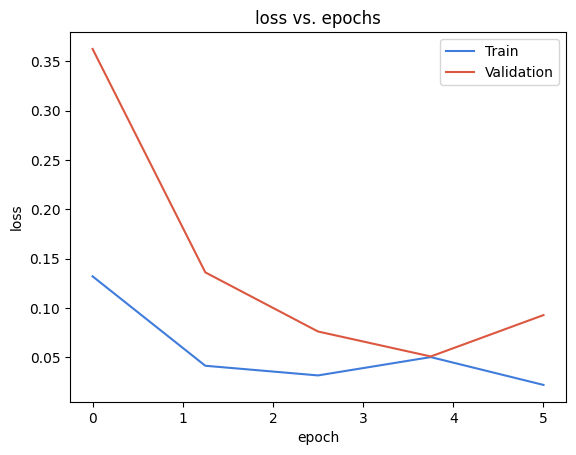

In [7]:
trainer.evaluate()
trainer.plot_loss()